## Introduction
We are ready to train the Cardiac Detection Model now!

## Imports:

* torch and torchvision for model and dataloader creation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* numpy data loading
* cv2 for drawing rectangles on images
* imgaug for augmentation pipeline
* Our CardiacDataset



In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa
from dataset import CardiacDataset


We create the dataset objects and the augmentation parameters to specify the augmentation parameters

In [2]:
train_root_path = "Processed-Heart-Detection/train/"
train_subjects = "train_subjects.npy"
val_root_path = "Processed-Heart-Detection/val/"
val_subjects = "val_subjects.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [3]:
train_dataset = CardiacDataset("rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [4]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [5]:
train_dataset = CardiacDataset(
    "./rsna_heart_detection.csv",
     train_subjects,
     train_root_path,
     augs = train_transforms)

val_dataset = CardiacDataset(
    "./rsna_heart_detection.csv",
     val_subjects,
     val_root_path,
     augs=None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 96 val images


Adapt batch size and num_workers according to your computing hardware.

In [6]:
batch_size = 8#TODO
num_workers = 4# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [7]:
from torchmetrics.classification import MulticlassMatthewsCorrCoef


## Model Creation

We use the same architecture as we used in the classifcation task with some small adaptations:

1. 4 outputs: Instead of predicting a binary label we need to estimate the location of the heart (xmin, ymin, xmax, ymax).
2. Loss function: Instead of using a cross entropy loss, we are going to use the L2 loss (Mean Squared Error), as we are dealing with continuous values.

In [8]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet50(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet50) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=2048, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
        #self.model = torchvision.models.resnet18(pretrained=True)
        #self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #self.model.fc = torch.nn.Linear(in_features=512 ,out_features=4)
        
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        #self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [15]:
#EVALUATION OF MODEL-----STAGE-2-------
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [9]:
import pytorch_lightning as pl
import torchvision
import torch
import torchmetrics
import cv2
import numpy as np

class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet50(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet50) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=2048, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        self.mcc = MulticlassMatthewsCorrCoef(num_classes=4)  # Assuming multiclass classification for MCC

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 20 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        
        # Convert bounding boxes to numpy arrays
        pred_boxes = pred.detach().cpu().numpy()
        target_boxes = label.detach().cpu().numpy()
    
        # Calculate accuracy
        accuracy = self.calculate_accuracy(pred_boxes, target_boxes)
    
        self.log("Val Accuracy", accuracy)

        if batch_idx % 20 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    

    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)
        
        
    def intersection_over_union(self, pred_box, target_box):
        # Determine the coordinates of the intersection rectangle
        x1 = max(pred_box[0], target_box[0])
        y1 = max(pred_box[1], target_box[1])
        x2 = min(pred_box[2], target_box[2])
        y2 = min(pred_box[3], target_box[3])
    
        # Compute the area of intersection rectangle
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
        # Compute the area of both the prediction and target boxes
        pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
        target_area = (target_box[2] - target_box[0] + 1) * (target_box[3] - target_box[1] + 1)
    
        # Compute the union area
        union_area = pred_area + target_area - intersection_area
    
        # Compute IoU
        iou = intersection_area / union_area
    
        return iou

    def calculate_accuracy(self, preds, labels, threshold=0.5):
        """
        preds: tensor of predicted bounding boxes (batch_size x 4)
        labels: tensor of ground truth bounding boxes (batch_size x 4)
        threshold: IoU threshold for considering a detection as correct
        """
        correct = 0
        total = len(preds)
    
        for pred_box, target_box in zip(preds, labels):
            iou = self.intersection_over_union(pred_box, target_box)
            if iou >= threshold:
                correct += 1
    
        accuracy = correct / total
    
        return accuracy
            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [17]:
import pytorch_lightning as pl
import torchvision
import torch
import torchmetrics
import cv2
import numpy as np

class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet50(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet50) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=2048, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 20 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        
        # Convert bounding boxes to numpy arrays
        pred_boxes = pred.detach().cpu().numpy()
        target_boxes = label.detach().cpu().numpy()
    
        # Calculate evaluation metrics for bounding box predictions
        iou = self.calculate_mean_iou(pred_boxes, target_boxes)
    
        # Log mean IoU
        self.log("Mean IoU", iou)

        if batch_idx % 20 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
            
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)
        
    def intersection_over_union(self, pred_box, target_box):
        # Determine the coordinates of the intersection rectangle
        x1 = max(pred_box[0], target_box[0])
        y1 = max(pred_box[1], target_box[1])
        x2 = min(pred_box[2], target_box[2])
        y2 = min(pred_box[3], target_box[3])
    
        # Compute the area of intersection rectangle
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
        # Compute the area of both the prediction and target boxes
        pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
        target_area = (target_box[2] - target_box[0] + 1) * (target_box[3] - target_box[1] + 1)
    
        # Compute the union area
        union_area = pred_area + target_area - intersection_area
    
        # Compute IoU
        iou = intersection_area / union_area
    
        return iou

    def calculate_mean_iou(self, preds, labels, threshold=0.5):
        """
        Calculate the mean Intersection over Union (IoU) for a batch of predictions and labels.
        preds: tensor of predicted bounding boxes (batch_size x 4)
        labels: tensor of ground truth bounding boxes (batch_size x 4)
        threshold: IoU threshold for considering a detection as correct
        """
        total_iou = 0
        total_samples = len(preds)

        for pred_box, target_box in zip(preds, labels):
            iou = self.intersection_over_union(pred_box, target_box)
            total_iou += iou

        mean_iou = total_iou / total_samples
        return mean_iou
            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [10]:
# Create the model object
model = CardiacDetectionModel()  # Instanciate the model

/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model.eval()

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [12]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

Train for at least 50 epochs to get a decent result.
100 epochs lead to great results.

You can train this on a CPU!

In [13]:
#!pip install tensorflow

In [14]:
import tensorflow as tf

2024-06-27 12:21:41.804956: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 12:21:42.050527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 12:21:42.732032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/",histogram_freq=1)

In [16]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                     default_root_dir="./weights", callbacks=checkpoint_callback,
                     max_epochs=100)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
#####---------STAY-ALERT---------TRAINING-IS-STARTING-------------#################

In [18]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | model   | ResNet                     | 23.5 M
1 | loss_fn | MSELoss                    | 0     
2 | mcc     | MulticlassMatthewsCorrCoef | 0     
-------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [26]:
print("Whats a code! KYA BAAT HAI")


Whats a code! KYA BAAT HAI


In [27]:
!pip install torchsummary

In [31]:
!pip install numpy

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs/lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 33064), started 2:55:04 ago. (Use '!kill 33064' to kill it.)

In [80]:
tensorboard --logdir logs/lightning_logs

Reusing TensorBoard on port 6006 (pid 43978), started 8:39:26 ago. (Use '!kill 43978' to kill it.)

In [33]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('logs/lightning_logs')

In [34]:
import matplotlib.pyplot as plt

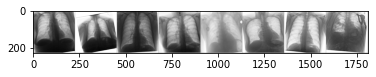

In [35]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
        
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Cardiac_Detection_Effort', img_grid)

In [36]:
#!pip install -U tensorboard-plugin-profile

In [37]:
%load_ext tensorboard
%tensorboard --logdir logs/lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 33064), started 2:55:46 ago. (Use '!kill 33064' to kill it.)

## Evaluation

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchmetrics import MatthewsCorrCoef
from sklearn.metrics import roc_curve, auc


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = CardiacDetectionModel.load_from_checkpoint("weight.ckpt")
model = CardiacDetectionModel.load_from_checkpoint("/home/narendra/ML/AI-IN-MEDICAL-MATERIALS/05-Detection/logs/lightning_logs/ResNet50_100Epoch/checkpoints/epoch=97-step=4900.ckpt", strict=False)

model.eval();
model.to(device)

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

Compute prediction for all validation samples

In [22]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

Compute mean deviation between prediction and labels for each coordinate

In [23]:
abs(preds-labels).mean(0)

tensor([4.1380, 4.3238, 3.4163, 4.8265])

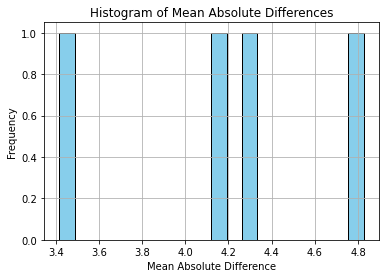

In [24]:
import torch
import matplotlib.pyplot as plt

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Compute mean absolute difference across all images
mean_abs_diff = abs_diff_per_image.mean(0)

# Convert mean absolute difference tensor to numpy array
mean_abs_diff_np = mean_abs_diff.numpy()

# Draw histogram
plt.hist(mean_abs_diff_np, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Mean Absolute Differences')
plt.xlabel('Mean Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


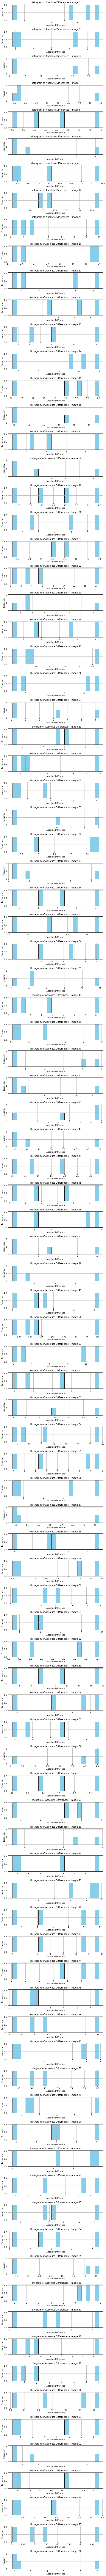

In [25]:
import torch
import matplotlib.pyplot as plt

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Get the number of validation images
num_images = abs_diff_per_image.size(0)

# Define the number of bins for the histograms
num_bins = 20

# Plot histograms for each image
fig, axs = plt.subplots(num_images, figsize=(8, num_images*2))

for i in range(num_images):
    axs[i].hist(abs_diff_per_image[i].numpy(), bins=num_bins, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of Absolute Differences - Image {i+1}')
    axs[i].set_xlabel('Absolute Difference')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

bins: 20 entries: [7.59343719e+00 1.10157013e+00 5.35275269e+00 6.80743408e+00
 5.37761688e+00 6.62720490e+00 2.18449402e+00 1.83628845e+00
 3.07714081e+00 1.15667725e+00 1.10971069e+00 3.82438660e+00
 1.27403259e+00 4.90666199e+00 1.14701843e+00 8.96926880e-01
 2.32423401e+00 3.91150284e+00 1.06666565e+00 8.39233398e-04
 1.34796143e+00 5.18704987e+00 5.99578857e-01 6.29623413e-01
 2.64225769e+00 1.39139557e+00 1.02413483e+01 2.16117859e+01
 1.89048691e+01 9.07028198e+00 1.43836975e+00 7.09808350e+00
 3.08319092e-01 1.95044708e+00 3.15405273e+00 1.39667816e+01
 2.04396820e+00 4.99325943e+00 4.70886230e+00 1.66368103e+00
 2.97279358e+00 4.07385254e+00 9.74821472e+00 1.25242157e+01
 3.36225891e+00 6.51249695e+00 1.12071228e+00 5.34399414e+00
 4.20034790e+00 2.11802673e+00 4.76211548e-01 8.25785828e+00
 4.99519348e+00 3.54005051e+00 4.23742676e+00 6.92916870e-01
 4.57453156e+00 2.06860733e+00 5.03747559e+00 6.01759338e+00
 2.24127960e+00 5.81211090e-01 4.57885742e-01 3.32493591e+00
 2.610

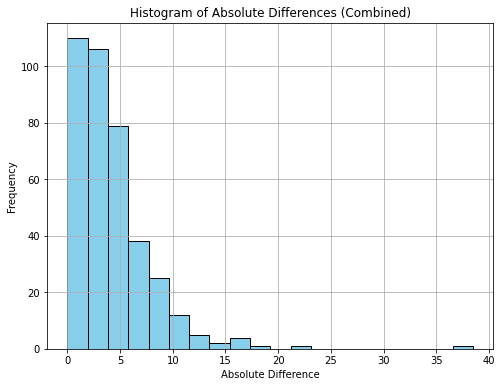

In [26]:
import torch
import matplotlib.pyplot as plt

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Flatten the tensor to combine results from all images
abs_diff_combined = abs_diff_per_image.flatten().numpy()

# Define the number of bins for the histogram
num_bins = 20

# Plot histogram for combined absolute differences
plt.figure(figsize=(8, 6))
plt.hist(abs_diff_combined, bins=num_bins, color='skyblue', edgecolor='black')
#plt.yscale('log')
print("bins:", num_bins, "entries:", abs_diff_combined)

plt.title('Histogram of Absolute Differences (Combined)')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


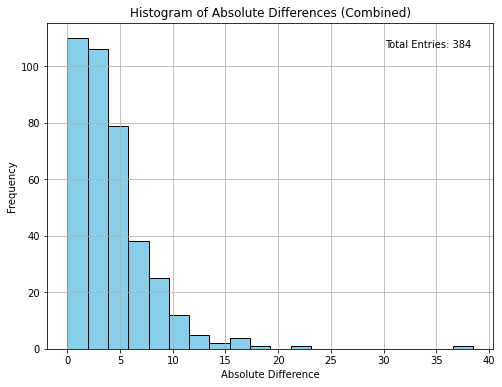

In [27]:
import torch
import matplotlib.pyplot as plt

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Flatten the tensor to combine results from all images
abs_diff_combined = abs_diff_per_image.flatten().numpy()

# Define the number of bins for the histogram
num_bins = 20

# Plot histogram for combined absolute differences
plt.figure(figsize=(8, 6))
plt.hist(abs_diff_combined, bins=num_bins, color='skyblue', edgecolor='black')
#plt.yscale('log')

# Calculate total number of entries
total_entries = len(abs_diff_combined)

plt.title('Histogram of Absolute Differences (Combined)')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)

# Add text annotation for total number of entries
plt.text(0.95, 0.95, f'Total Entries: {total_entries}', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()


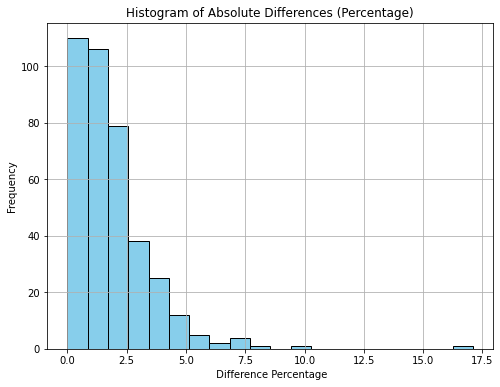

In [28]:
import torch
import matplotlib.pyplot as plt

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Flatten the tensor to combine results from all images
abs_diff_combined = abs_diff_per_image.flatten().numpy()

# Define the number of bins for the histogram
num_bins = 20

# Plot histogram for combined absolute differences
plt.figure(figsize=(8, 6))
plt.hist((abs_diff_combined / 225)*100, bins=num_bins, color='skyblue', edgecolor='black')
#plt.yscale('log')

plt.title('Histogram of Absolute Differences (Percentage)')
plt.xlabel(' Difference Percentage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

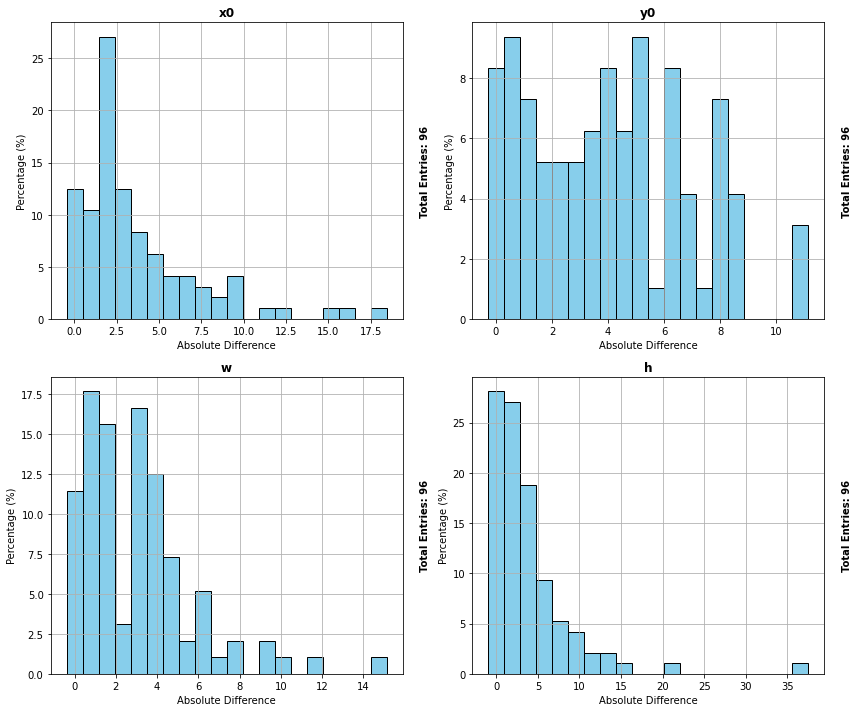

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Transpose the tensor to separate results for each parameter
abs_diff_per_parameter = abs_diff_per_image.transpose(0, 1)

# Define parameter names
parameter_names = ['x0', 'y0', 'w', 'h']

# Define the number of bins for the histograms
num_bins = 20

# Create subplots for each parameter
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    # Calculate percentage of absolute differences of parameter i
    abs_diff_i = abs_diff_per_parameter[i].numpy().flatten()
    total_entries = len(abs_diff_i)
    hist, bins = np.histogram(abs_diff_i, bins=num_bins)
    percentage_hist = hist / total_entries * 100
    
    # Plot histogram for absolute differences of parameter i
    ax.bar(bins[:-1], percentage_hist, width=bins[1]-bins[0], color='skyblue', edgecolor='black')
    ax.set_title(parameter_names[i], fontweight='bold')  # Bold title
    ax.set_xlabel('Absolute Difference')
    ax.set_ylabel('Percentage (%)')
    ax.grid(True)
    
    # Calculate number of entries and display in bold on the right side
    ax.text(1.05, 0.5, f'Total Entries: {total_entries}', transform=ax.transAxes, fontsize=10, verticalalignment='center', fontweight='bold', rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


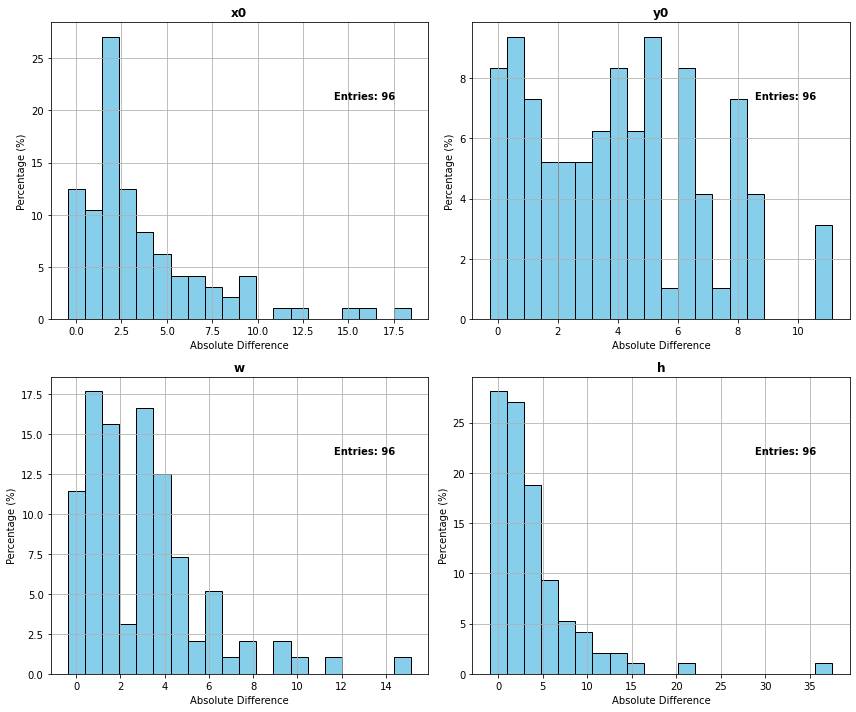

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Calculate absolute difference for each image
abs_diff_per_image = torch.abs(preds - labels)

# Transpose the tensor to separate results for each parameter
abs_diff_per_parameter = abs_diff_per_image.transpose(0, 1)

# Define parameter names
parameter_names = ['x0', 'y0', 'w', 'h']

# Define the number of bins for the histograms
num_bins = 20

# Create subplots for each parameter
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    # Calculate percentage of absolute differences of parameter i
    abs_diff_i = abs_diff_per_parameter[i].numpy().flatten()
    total_entries = len(abs_diff_i)
    hist, bins = np.histogram(abs_diff_i, bins=num_bins)
    percentage_hist = hist / total_entries * 100
    
    # Plot histogram for absolute differences of parameter i
    ax.bar(bins[:-1], percentage_hist, width=bins[1]-bins[0], color='skyblue', edgecolor='black')
    ax.set_title(parameter_names[i], fontweight='bold')  # Bold title
    ax.set_xlabel('Absolute Difference')
    ax.set_ylabel('Percentage (%)')
    ax.grid(True)
    
    # Calculate number of entries and display in bold on the right side
    ax.text(0.75, 0.75, f'Entries: {total_entries}', transform=ax.transAxes, fontsize=10, verticalalignment='center', fontweight='bold', rotation=360)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


/home/narendra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confus

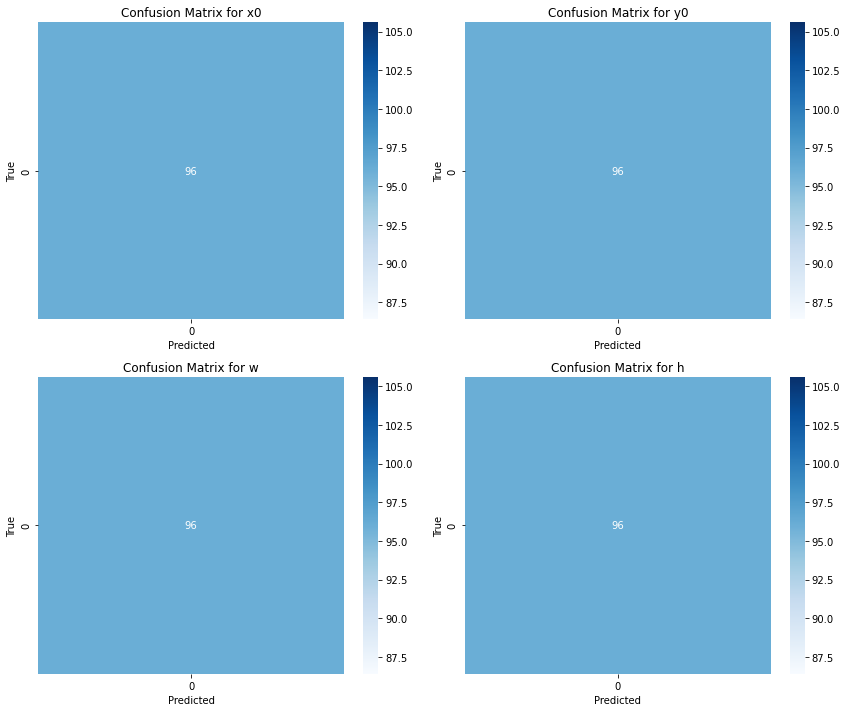

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert absolute differences to predicted and true labels for each variable
pred_labels = []
true_labels = []

for i in range(4):
    pred_labels.append(np.where(abs_diff_per_parameter[i] > 0, 1, 0))
    true_labels.append(np.ones_like(pred_labels[i]))

# Plot confusion matrices
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    conf_matrix = confusion_matrix(true_labels[i].flatten(), pred_labels[i].flatten())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {parameter_names[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()


Example prediction:

tensor([ 92,  63, 194, 179])


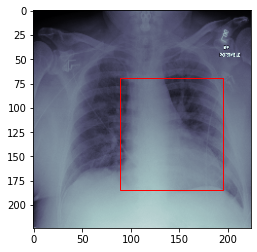

In [32]:
IDX = 11  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

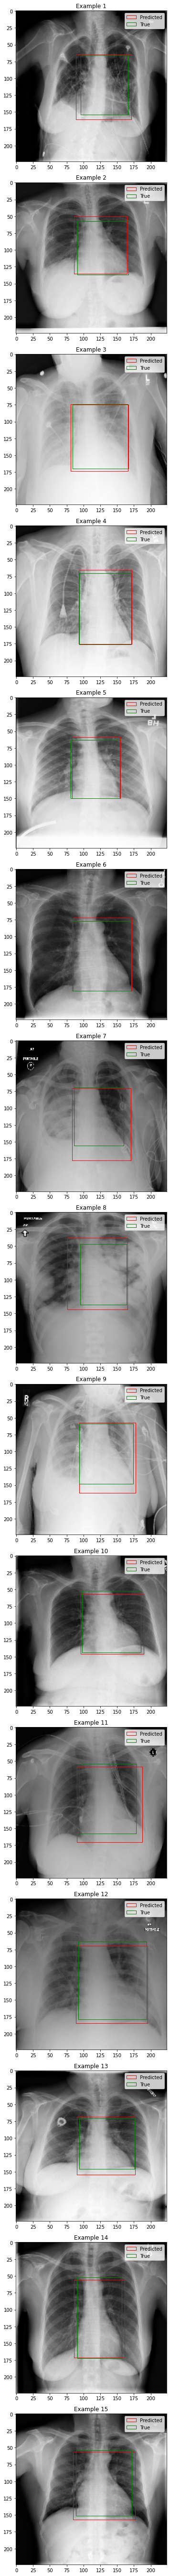

In [33]:
import matplotlib.pyplot as plt
import torch

def plot_example_predictions(model, data_loader, device, num_examples=15):
    model.eval()
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, num_examples * 5))
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_examples:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_examples:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                ax = axes[count] if num_examples > 1 else axes
                ax.imshow(image, cmap='gray')
                
                # Plot predicted bounding box
                pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                ax.add_patch(pred_rect)
                
                # Plot true bounding box
                true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                ax.add_patch(true_rect)
                
                ax.legend()
                ax.set_title(f'Example {count + 1}')
                count += 1
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_example_predictions(model, val_loader, device)


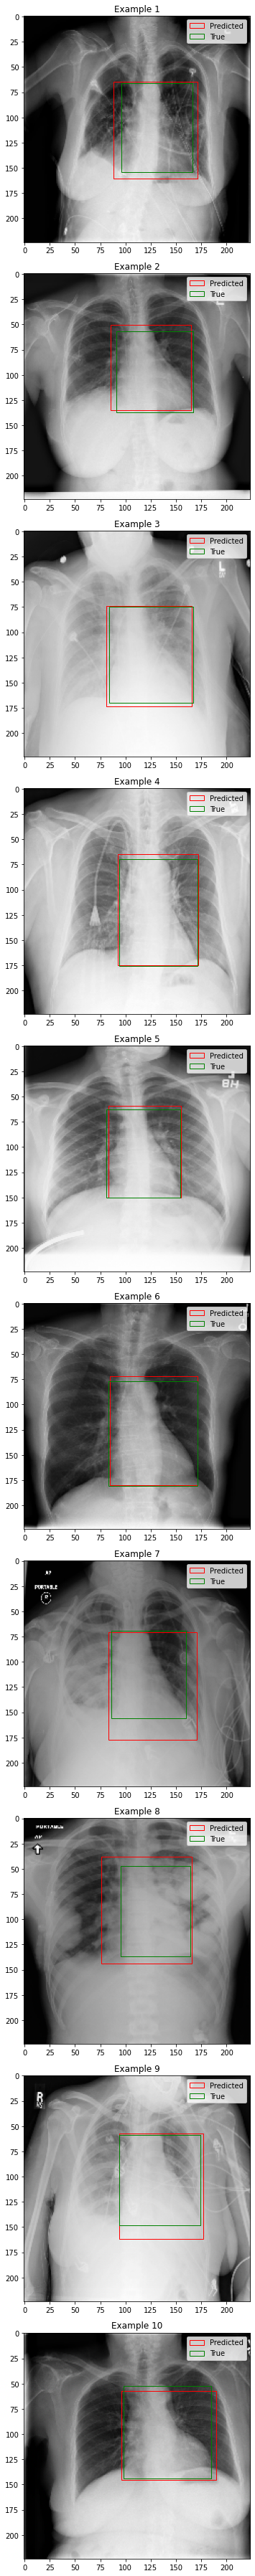

In [34]:
import matplotlib.pyplot as plt
import torch

def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

def plot_example_predictions_with_overlap(model, data_loader, device, num_examples=10, min_overlap=0.6):
    model.eval()
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, num_examples * 5))
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_examples:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_examples:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                # Calculate IoU
                iou = calculate_iou(pred_bbox, true_bbox)
                
                if iou > min_overlap:
                    ax = axes[count] if num_examples > 1 else axes
                    ax.imshow(image, cmap='gray')
                    
                    # Plot predicted bounding box
                    pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                    ax.add_patch(pred_rect)
                    
                    # Plot true bounding box
                    true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                    ax.add_patch(true_rect)
                    
                    ax.legend()
                    ax.set_title(f'Example {count + 1}')
                    count += 1
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_example_predictions_with_overlap(model, val_loader, device, min_overlap=0.6)


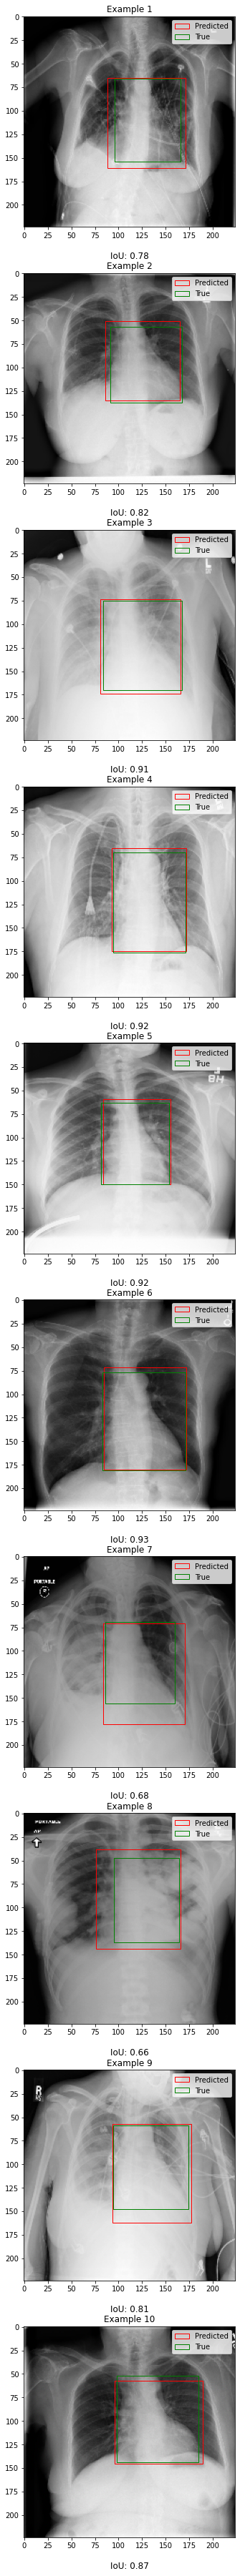

In [35]:
import matplotlib.pyplot as plt
import torch

def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

def plot_example_predictions(model, data_loader, device, num_examples=10):
    model.eval()
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, num_examples * 5))
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_examples:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_examples:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                ax = axes[count] if num_examples > 1 else axes
                ax.imshow(image, cmap='gray')
                
                # Plot predicted bounding box
                pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                ax.add_patch(pred_rect)
                
                # Plot true bounding box
                true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                ax.add_patch(true_rect)
                
                # Calculate IoU
                iou = calculate_iou(pred_bbox, true_bbox)
                
                # Add IoU as text on the plot
                ax.text(0.5, -0.15, f'IoU: {iou:.2f}', size=12, ha='center', transform=ax.transAxes)
                
                ax.legend()
                ax.set_title(f'Example {count + 1}')
                count += 1
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_example_predictions(model, val_loader, device)


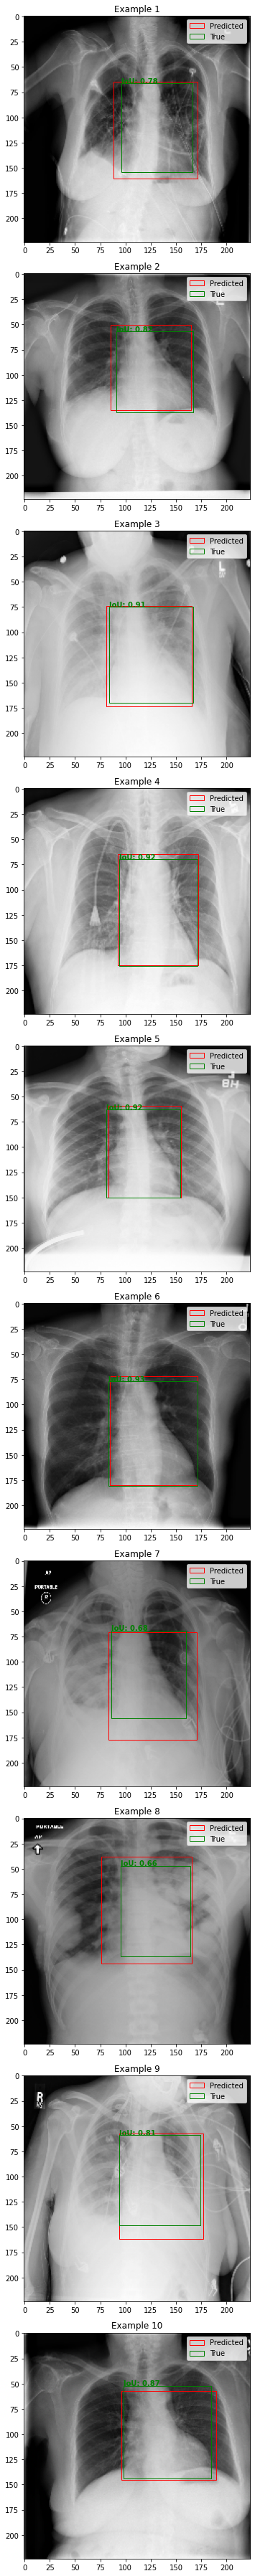

In [36]:
import matplotlib.pyplot as plt
import torch

def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

def plot_example_predictions(model, data_loader, device, num_examples=10):
    model.eval()
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, num_examples * 5))
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_examples:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_examples:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                ax = axes[count] if num_examples > 1 else axes
                ax.imshow(image, cmap='gray')
                
                # Plot predicted bounding box
                pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                ax.add_patch(pred_rect)
                
                # Plot true bounding box
                true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                ax.add_patch(true_rect)
                
                # Calculate IoU
                iou = calculate_iou(pred_bbox, true_bbox)
                
                # Add IoU as annotation on the plot
                ax.annotate(f'IoU: {iou:.2f}', (true_bbox[0], true_bbox[1]), color='g', fontsize=10, weight='bold')
                
                ax.legend()
                ax.set_title(f'Example {count + 1}')
                count += 1
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_example_predictions(model, val_loader, device)


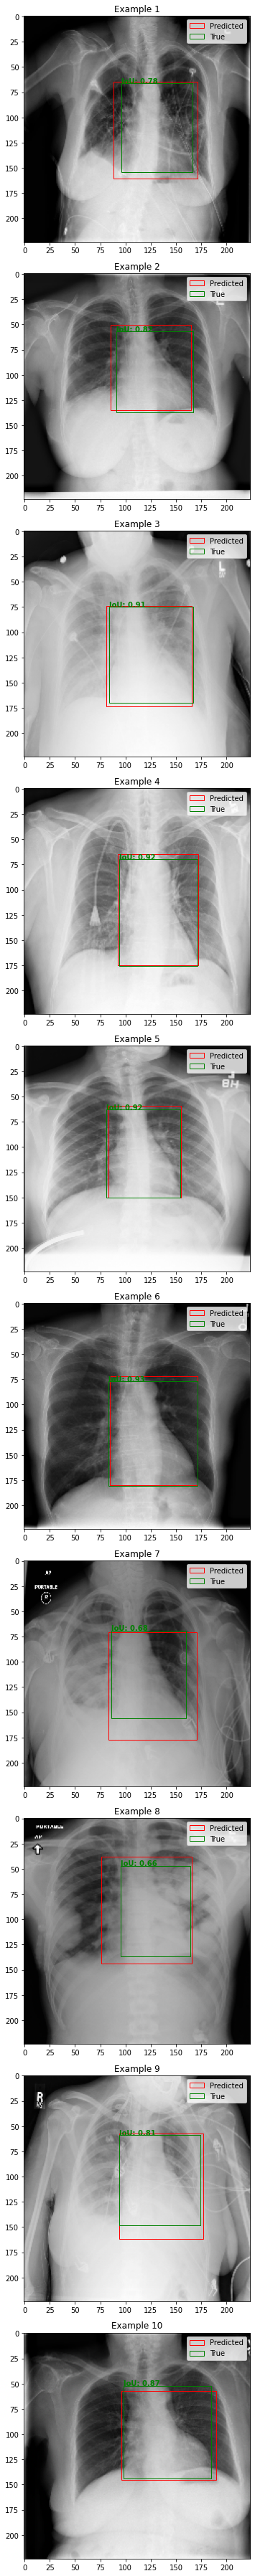

In [37]:
import matplotlib.pyplot as plt
import torch

def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

def plot_example_predictions(model, data_loader, device, num_examples=10, save_pdf=False, save_png=False):
    model.eval()
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, num_examples * 5))
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_examples:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_examples:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                ax = axes[count] if num_examples > 1 else axes
                ax.imshow(image, cmap='gray')
                
                # Plot predicted bounding box
                pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                ax.add_patch(pred_rect)
                
                # Plot true bounding box
                true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                ax.add_patch(true_rect)
                
                # Calculate IoU
                iou = calculate_iou(pred_bbox, true_bbox)
                
                # Add IoU as annotation on the plot
                ax.annotate(f'IoU: {iou:.2f}', (true_bbox[0], true_bbox[1]), color='g', fontsize=10, weight='bold')
                
                ax.legend()
                ax.set_title(f'Example {count + 1}')
                count += 1
    
    plt.tight_layout()
    
    # Save as PDF if specified
    if save_pdf:
        plt.savefig('ResNet50_predictions.pdf', format='pdf')
    
    # Save as PNG if specified
    if save_png:
        plt.savefig('ResNet50_predictions.png', format='png', dpi=300)  # Adjust dpi for resolution
    
    plt.show()

# Call the function
plot_example_predictions(model, val_loader, device, save_pdf=True, save_png=True)


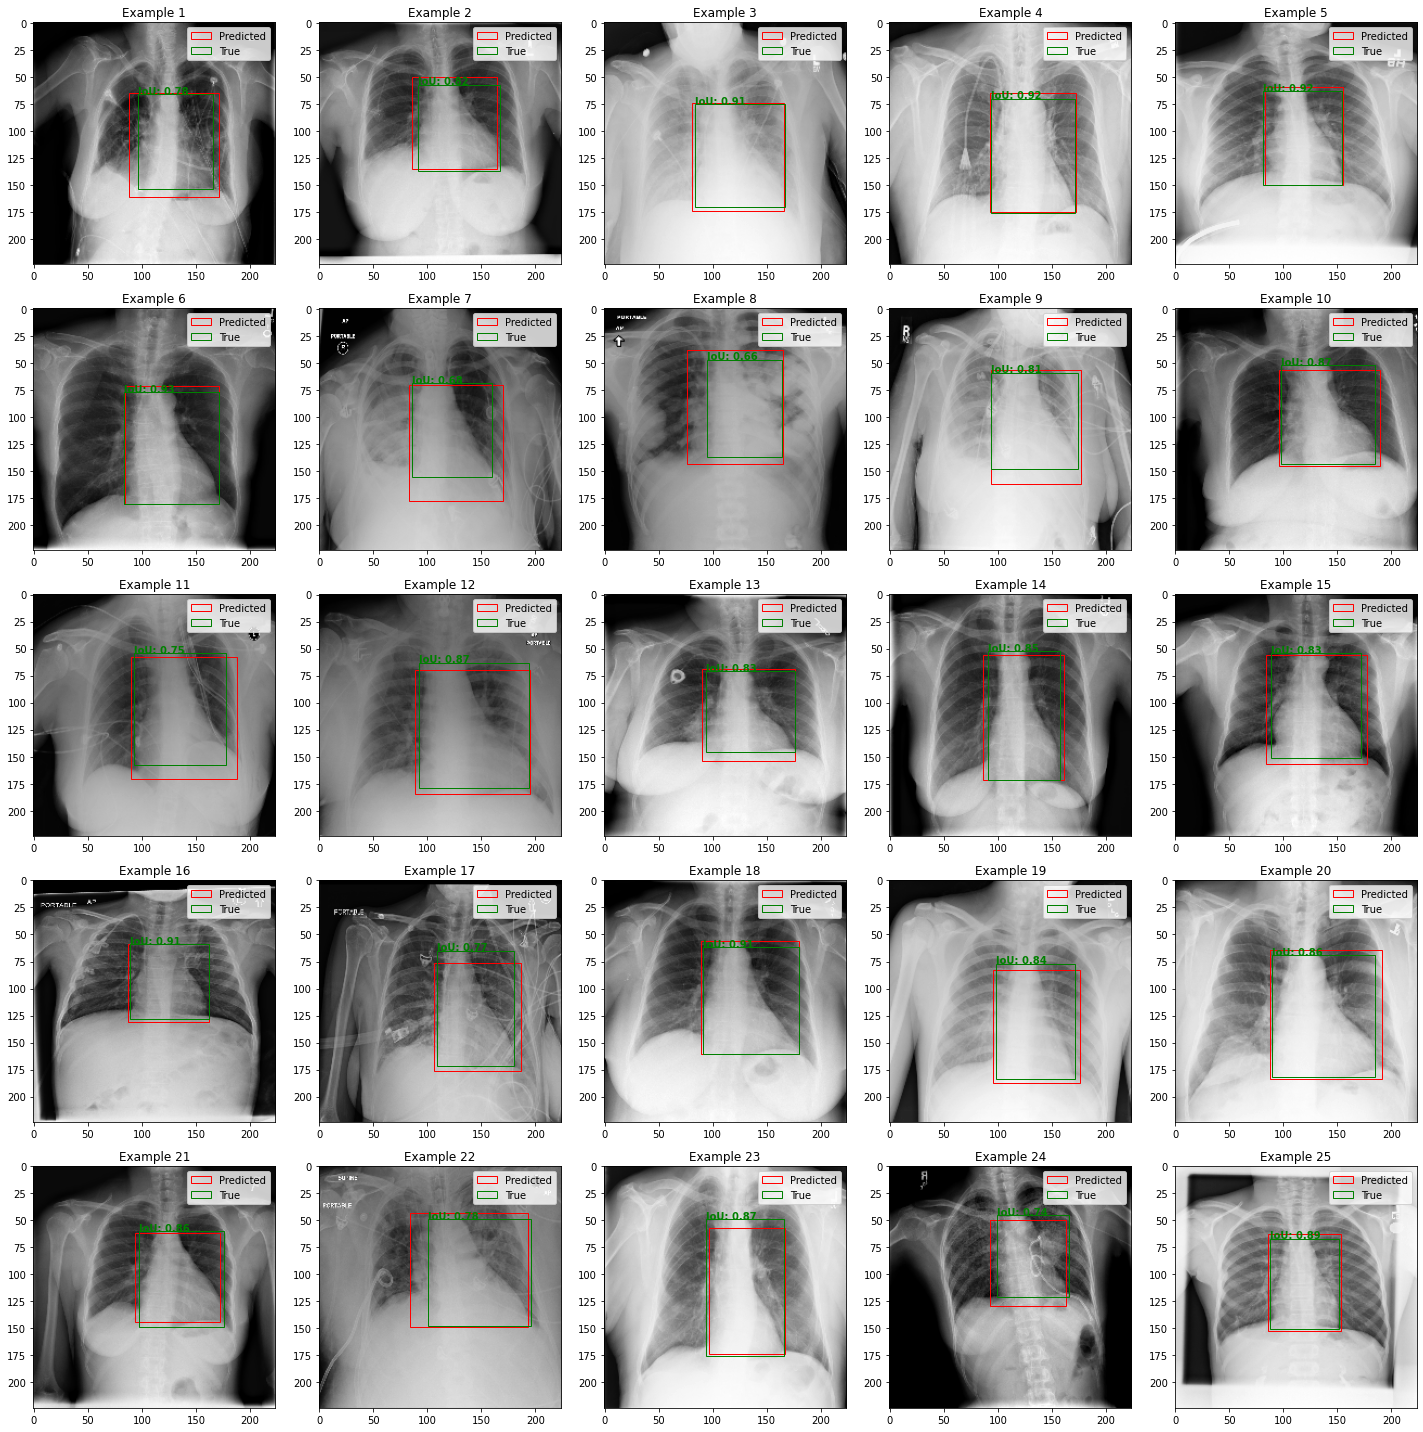

In [38]:
Są chwile, gdy trzeba działać razem — pomóżmy naszemu doktorantowi, Sebastianowi Wildowiczowi, zebrać środki na leczenie i rehabilitację jego 2-letniego syna Olusia.

„Na naszego jedynego synka spadła straszna diagnoza. Oluś choruje na przerażającą chorobę, neuroblastomę IV stopnia. To jeden z najgorszych nowotworów wieku dziecięcego, wybierający tych najmłodszych, najbardziej bezbronnych, niewinnych. Błagamy o pomoc, żeby uratować życie Olusia! On ma tylko dwa latka, nie może przecież umrzeć…”

Aby ta dramatyczna historia miała szansę na dobre zakończenie, potrzebne jest nasze wsparcie. Syn Sebastiana Wildowicza jest w trakcie intensywnego leczenia, przed nim wiele wyzwań, a my możemy sprawić, że terapia, kosztowna szczepionka przeciw nawrotowi i rehabilitacja będą osiągalne.import matplotlib.pyplot as plt
import torch

def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

def plot_example_predictions(model, data_loader, device, num_rows=5, num_cols=5, save_pdf=False, save_png=False):
    model.eval()
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_rows * num_cols:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_rows * num_cols:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                row_idx = count // num_cols
                col_idx = count % num_cols
                
                ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
                ax.imshow(image, cmap='gray')
                
                # Plot predicted bounding box
                pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                ax.add_patch(pred_rect)
                
                # Plot true bounding box
                true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                ax.add_patch(true_rect)
                
                # Calculate IoU
                iou = calculate_iou(pred_bbox, true_bbox)
                
                # Add IoU as annotation on the plot
                ax.annotate(f'IoU: {iou:.2f}', (true_bbox[0], true_bbox[1]), color='g', fontsize=10, weight='bold')
                
                ax.legend()
                ax.set_title(f'Example {count + 1}')
                count += 1
    
    plt.tight_layout()
    
    # Save as PDF if specified
    if save_pdf:
        plt.savefig('ResNet50_predictions.pdf', format='pdf')
    
    # Save as PNG if specified
    if save_png:
        plt.savefig('ResNet50_predictions.png', format='png', dpi=300)  # Adjust dpi for resolution
    
    plt.show()

# Call the function
plot_example_predictions(model, val_loader, device, save_pdf=True, save_png=True)


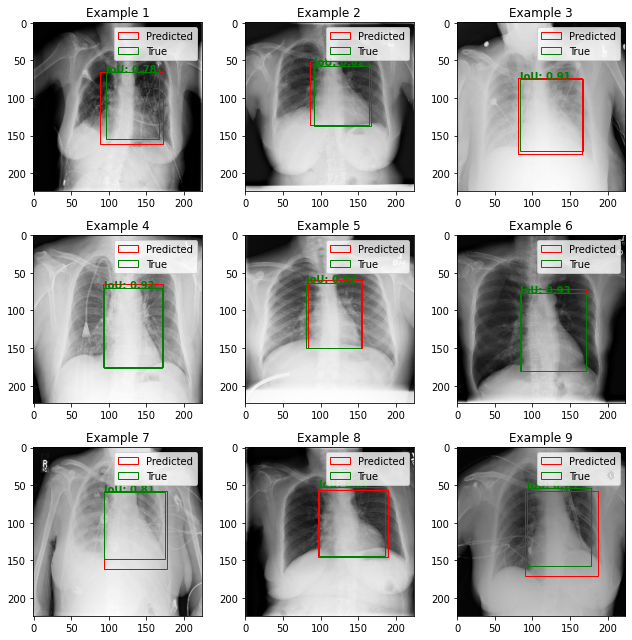

In [39]:
import matplotlib.pyplot as plt
import torch

def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

def plot_example_predictions(model, data_loader, device, num_rows=3, num_cols=3, save_pdf=False, save_png=False, min_iou=0.75):
    model.eval()
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 9))  # Adjust figsize for a 3x3 grid
    
    with torch.no_grad():
        count = 0
        for i, (x_ray, labels) in enumerate(data_loader):
            if count >= num_rows * num_cols:
                break
            x_ray = x_ray.to(device)
            preds = model(x_ray).cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(x_ray.shape[0]):
                if count >= num_rows * num_cols:
                    break
                image = x_ray[j].cpu().numpy().squeeze()
                pred_bbox = preds[j]
                true_bbox = labels[j]
                
                # Calculate IoU
                iou = calculate_iou(pred_bbox, true_bbox)
                
                if iou >= min_iou:
                    row_idx = count // num_cols
                    col_idx = count % num_cols

                    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
                    ax.imshow(image, cmap='gray')

                    # Plot predicted bounding box
                    pred_rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], edgecolor='r', facecolor='none', label='Predicted')
                    ax.add_patch(pred_rect)

                    # Plot true bounding box
                    true_rect = plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2] - true_bbox[0], true_bbox[3] - true_bbox[1], edgecolor='g', facecolor='none', label='True')
                    ax.add_patch(true_rect)

                    # Add IoU as annotation on the plot
                    ax.annotate(f'IoU: {iou:.2f}', (true_bbox[0], true_bbox[1]), color='g', fontsize=10, weight='bold')

                    ax.legend()
                    ax.set_title(f'Example {count + 1}')
                    count += 1
    
    plt.tight_layout()
    
    # Save as PDF if specified
    if save_pdf:
        plt.savefig('ResNet50_predictions.pdf', format='pdf')
    
    # Save as PNG if specified
    if save_png:
        plt.savefig('ResNet50_predictions.png', format='png', dpi=300)  # Adjust dpi for resolution
    
    plt.show()

# Call the function with min_iou=0.75
plot_example_predictions(model, val_loader, device, save_pdf=True, save_png=True, min_iou=0.75)


In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure true_labels and predicted_labels are available
# Get the true and predicted class labels for each sample
true_labels = np.argmax(all_labels, axis=1)
predicted_labels = np.argmax(all_preds, axis=1)
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)


NameError: name 'all_labels' is not defined

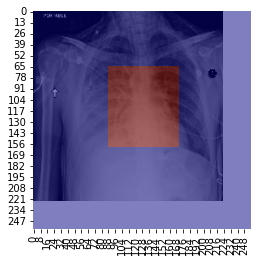

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
# Assuming val_loader is your validation DataLoader
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        x_ray, labels = batch
        x_ray = x_ray.to(device)
        labels = labels.to(device)
        
        preds = model(x_ray)
        
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Ensure bounding box coordinates are within image dimensions
def clamp_bbox(bbox, img_size):
    x0, y0, x1, y1 = bbox
    x0 = max(0, min(int(x0), img_size[1] - 1))
    y0 = max(0, min(int(y0), img_size[0] - 1))
    x1 = max(0, min(int(x1), img_size[1] - 1))
    y1 = max(0, min(int(y1), img_size[0] - 1))
    return [x0, y0, x1, y1]

# Generate heatmap for each predicted bounding box
def generate_heatmap(image, bbox, img_size=(256, 256)):
    heatmap = np.zeros(img_size)
    x0, y0, x1, y1 = clamp_bbox(bbox, img_size)
    heatmap[y0:y1, x0:x1] = 1
    return heatmap

# Plot heatmap
def plot_heatmap(image, heatmap):
    plt.imshow(image, cmap='gray')
    sns.heatmap(heatmap, alpha=0.5, cmap='jet', cbar=False)
    plt.show()

# Example: Generate and plot heatmap for the first image in the validation set
image = x_ray[0].cpu().numpy().squeeze()
bbox = all_preds[0]
heatmap = generate_heatmap(image, bbox)
plot_heatmap(image, heatmap)


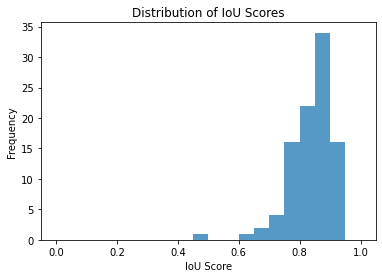

In [42]:
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def plot_iou_distribution(all_labels, all_preds):
    iou_scores = []
    for true_bbox, pred_bbox in zip(all_labels, all_preds):
        iou = compute_iou(true_bbox, pred_bbox)
        iou_scores.append(iou)
    
    plt.hist(iou_scores, bins=20, range=(0, 1), alpha=0.75)
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of IoU Scores')
    plt.show()

# Ensure that all_labels and all_preds are defined as in previous code
plot_iou_distribution(all_labels, all_preds)


Mean IoU: 0.8360
Standard Deviation of IoU: 0.0737


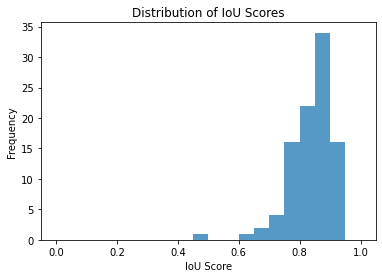

In [43]:
import numpy as np

def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def plot_iou_distribution(all_labels, all_preds):
    iou_scores = []
    for true_bbox, pred_bbox in zip(all_labels, all_preds):
        iou = compute_iou(true_bbox, pred_bbox)
        iou_scores.append(iou)

    iou_scores = np.array(iou_scores)
    mean_iou = np.mean(iou_scores)
    std_iou = np.std(iou_scores)

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Standard Deviation of IoU: {std_iou:.4f}")

    plt.hist(iou_scores, bins=20, range=(0, 1), alpha=0.75)
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of IoU Scores')
    plt.show()

# Ensure that all_labels and all_preds are defined as in previous code
plot_iou_distribution(all_labels, all_preds)

In [45]:
!pip install numpy matplotlib scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 5.0 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 9.3 MB/s eta 0:00:00m eta 0:00:010:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 7.7 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 8.9 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 214.4 kB/s eta 0:00:006m0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 1.2 MB/s eta 0:00:00? eta -:--:--
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 3.8 MB/s eta 0:00:0

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def plot_iou_distribution(all_labels, all_preds):
    iou_scores = []
    for true_bbox, pred_bbox in zip(all_labels, all_preds):
        iou = compute_iou(true_bbox, pred_bbox)
        iou_scores.append(iou)

    iou_scores = np.array(iou_scores)
    original_mean = np.mean(iou_scores)
    original_std = np.std(iou_scores)

    # Bootstrap resampling
    means, stds = bootstrap.bootstrap((iou_scores, np.mean, np.std), num_bootstrap)

    # Calculate the standard error of the mean and standard deviation
    mean_error = np.std(means)
    std_error = np.std(stds)

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the histogram
    ax.hist(iou_scores, bins=20, range=(0, 1), alpha=0.75)
    ax.set_xlabel('IoU Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of IoU Scores')

    # Add error bars for the mean and standard deviation
    ax.errorbar(original_mean, 0, xerr=mean_error, capsize=5, fmt='ro', label='Mean IoU')
    ax.errorbar(original_std, 0, xerr=std_error, capsize=5, fmt='bo', label='Std. Dev. IoU')

    # Add a legend
    ax.legend()

    plt.show()

# Example usage
all_labels = [
    [10, 20, 50, 60],
    [25, 35, 75, 85],
    [15, 30, 65, 70],
    [5, 10, 40, 45],
    [20, 25, 60, 65]
]

all_preds = [
    [12, 18, 48, 62],
    [20, 40, 70, 90],
    [18, 32, 62, 68],
    [7, 12, 38, 43],
    [22, 27, 58, 63]
]

plot_iou_distribution(all_labels, all_preds)

AttributeError: 'function' object has no attribute 'bootstrap'

Awesome, looks like we got a working heart detection!

In [60]:
import torch
from torchviz import make_dot
from torch import nn

# Define the CardiacDetectionModel
class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(64)
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(128),
                nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    nn.BatchNorm2d(128)
                )
            ),
            nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(256),
                nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    nn.BatchNorm2d(256)
                )
            ),
            nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512),
                nn.Sequential(
                    nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    nn.BatchNorm2d(512)
                )
            ),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Linear(in_features=512, out_features=4, bias=True)
        )
        self.loss_fn = nn.MSELoss()
        self.mcc = nn.Identity()  # Replace with the actual implementation if available

    def forward(self, x):
        return self.model(x)

# Create an instance of the model and visualize it
model = CardiacDetectionModel()
x = torch.randn(1, 1, 224, 224)  # Dummy input tensor
y = model(x)

# Visualize the model
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("CardiacDetectionModel", format="png")


RuntimeError: Given groups=1, weight of size [128, 64, 1, 1], expected input[1, 128, 28, 28] to have 64 channels, but got 128 channels instead

In [61]:
import torch
from torchviz import make_dot
from torch import nn

# Define the CardiacDetectionModel
class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        self.model = nn.Sequential(
            # Your model definition here
        )
        self.loss_fn = nn.MSELoss()
        self.mcc = nn.Identity()  # Replace with the actual implementation if available

    def forward(self, x):
        return self.model(x)

# Create an instance of the model
model = CardiacDetectionModel()

# Define a dummy input tensor
x = torch.randn(1, 1, 224, 224)

# Convert the model to ONNX format
onnx_path = "cardiac_detection_model.onnx"
torch.onnx.export(model, x, onnx_path, verbose=True)

# Open the resulting ONNX file in Netron using the provided link
import netron
netron.start(onnx_path)


Exported graph: graph(%onnx::Identity_0 : Float(1, 1, 224, 224, strides=[50176, 50176, 224, 1], requires_grad=0, device=cpu)):
  %1 : Float(1, 1, 224, 224, strides=[50176, 50176, 224, 1], requires_grad=0, device=cpu) = onnx::Identity(%onnx::Identity_0)
  return (%1)



ModuleNotFoundError: No module named 'netron'

In [62]:
import torch
from torchviz import make_dot
#from cardiac_detection_model import CardiacDetectionModel  # Assume this is your model file

# Initialize the model
model = CardiacDetectionModel()

# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 1, 224, 224)  # Adjust the shape as per your input dimensions

# Perform a forward pass using the dummy input
output = model(dummy_input)

# Generate the visualization graph
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph as a PDF file
graph.render("cardiac_detection_model", format="pdf")

# Optionally, display the graph
graph.view()


'cardiac_detection_model.pdf'

In [63]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
import torchvision
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import cv2

class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = nn.MSELoss()
        self.mcc = MulticlassMatthewsCorrCoef(num_classes=4)  # Assuming multiclass classification for MCC

    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        
        # Convert bounding boxes to numpy arrays
        pred_boxes = pred.detach().cpu().numpy()
        target_boxes = label.detach().cpu().numpy()
    
        # Calculate accuracy
        accuracy = self.calculate_accuracy(pred_boxes, target_boxes)
    
        self.log("Val Accuracy", accuracy)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)
        
    def intersection_over_union(self, pred_box, target_box):
        # Determine the coordinates of the intersection rectangle
        x1 = max(pred_box[0], target_box[0])
        y1 = max(pred_box[1], target_box[1])
        x2 = min(pred_box[2], target_box[2])
        y2 = min(pred_box[3], target_box[3])
    
        # Compute the area of intersection rectangle
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
        # Compute the area of both the prediction and target boxes
        pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
        target_area = (target_box[2] - target_box[0] + 1) * (target_box[3] - target_box[1] + 1)
    
        # Compute the union area
        union_area = pred_area + target_area - intersection_area
    
        # Compute IoU
        iou = intersection_area / union_area
    
        return iou

    def calculate_accuracy(self, preds, labels, threshold=0.5):
        """
        preds: tensor of predicted bounding boxes (batch_size x 4)
        labels: tensor of ground truth bounding boxes (batch_size x 4)
        threshold: IoU threshold for considering a detection as correct
        """
        correct = 0
        total = len(preds)
    
        for pred_box, target_box in zip(preds, labels):
            iou = self.intersection_over_union(pred_box, target_box)
            if iou >= threshold:
                correct += 1
    
        accuracy = correct / total
    
        return accuracy
            
    def configure_optimizers(self):
        return [self.optimizer]

# Now, use torchviz to visualize the model
import torch
from torchviz import make_dot

# Initialize the model
model = CardiacDetectionModel()

# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 1, 224, 224)  # Adjust the shape as per your input dimensions

# Perform a forward pass using the dummy input
output = model(dummy_input)

# Generate the visualization graph
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph as a PDF file
graph.render("cardiac_detection_model", format="pdf")

# Optionally, display the graph
graph.view()


/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'cardiac_detection_model.pdf'

In [64]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
import torchvision
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import cv2

class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = nn.MSELoss()
        self.mcc = MulticlassMatthewsCorrCoef(num_classes=4)  # Assuming multiclass classification for MCC

    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        
        # Convert bounding boxes to numpy arrays
        pred_boxes = pred.detach().cpu().numpy()
        target_boxes = label.detach().cpu().numpy()
    
        # Calculate accuracy
        accuracy = self.calculate_accuracy(pred_boxes, target_boxes)
    
        self.log("Val Accuracy", accuracy)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)
        
    def intersection_over_union(self, pred_box, target_box):
        # Determine the coordinates of the intersection rectangle
        x1 = max(pred_box[0], target_box[0])
        y1 = max(pred_box[1], target_box[1])
        x2 = min(pred_box[2], target_box[2])
        y2 = min(pred_box[3], target_box[3])
    
        # Compute the area of intersection rectangle
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
        # Compute the area of both the prediction and target boxes
        pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
        target_area = (target_box[2] - target_box[0] + 1) * (target_box[3] - target_box[1] + 1)
    
        # Compute the union area
        union_area = pred_area + target_area - intersection_area
    
        # Compute IoU
        iou = intersection_area / union_area
    
        return iou

    def calculate_accuracy(self, preds, labels, threshold=0.5):
        """
        preds: tensor of predicted bounding boxes (batch_size x 4)
        labels: tensor of ground truth bounding boxes (batch_size x 4)
        threshold: IoU threshold for considering a detection as correct
        """
        correct = 0
        total = len(preds)
    
        for pred_box, target_box in zip(preds, labels):
            iou = self.intersection_over_union(pred_box, target_box)
            if iou >= threshold:
                correct += 1
    
        accuracy = correct / total
    
        return accuracy
            
    def configure_optimizers(self):
        return [self.optimizer]

# Now, use torchviz to visualize the model
import torch
from torchviz import make_dot

# Initialize the model
model = CardiacDetectionModel()

# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 1, 224, 224)  # Adjust the shape as per your input dimensions

# Perform a forward pass using the dummy input
output = model(dummy_input)

# Generate the visualization graph
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph as a PDF file
graph.render("cardiac_detection_model", format="pdf")

# Optionally, display the graph
graph.view()


/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'cardiac_detection_model.pdf'

In [65]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchviz import make_dot


# Initialize the model
model = CardiacDetectionModel()

# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 1, 224, 224)  # Adjust the shape as per your input dimensions

# Perform a forward pass using the dummy input
output = model(dummy_input)

# Generate the visualization graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph.format = 'pdf'

# Customize the node colors
for node in graph.body:
    if 'conv' in node:
        node = node.replace(']', ', fillcolor="lightblue", style="filled"]')
    elif 'bn' in node:
        node = node.replace(']', ', fillcolor="lightgreen", style="filled"]')
    elif 'relu' in node:
        node = node.replace(']', ', fillcolor="lightyellow", style="filled"]')
    elif 'pool' in node:
        node = node.replace(']', ', fillcolor="lightpink", style="filled"]')
    elif 'fc' in node:
        node = node.replace(']', ', fillcolor="orange", style="filled"]')

# Save and render the graph
graph.render(filename='resnet18_cardiac_detection_model_colored', directory='.')

# Optionally display the graph
graph.view()


/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'resnet18_cardiac_detection_model_colored.pdf'

In [66]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchviz import make_dot

class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        
        # Use weights instead of pretrained to avoid warnings
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = nn.Linear(in_features=512, out_features=4)

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CardiacDetectionModel()

# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 1, 224, 224)  # Adjust the shape as per your input dimensions

# Perform a forward pass using the dummy input
output = model(dummy_input)

# Generate the visualization graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph.format = 'pdf'

# Customize the node colors
def customize_nodes(graph):
    for node in graph.body:
        if 'conv' in node:
            node.replace(']', ', fillcolor="lightblue", style="filled"]')
        elif 'bn' in node:
            node.replace(']', ', fillcolor="lightgreen", style="filled"]')
        elif 'relu' in node:
            node.replace(']', ', fillcolor="lightyellow", style="filled"]')
        elif 'pool' in node:
            node.replace(']', ', fillcolor="lightpink", style="filled"]')
        elif 'fc' in node:
            node.replace(']', ', fillcolor="orange", style="filled"]')
        elif 'neuron' in node:
            node.replace(']', ', fillcolor="lightgrey", style="filled"]')
    return graph

# Add intermediate layers (neurons) visualization
def add_intermediate_neurons(graph):
    for node in graph.body:
        if 'conv' in node or 'fc' in node:
            # Add a neuron layer after each conv and fc layer
            neuron_layer = node.replace('conv', 'neuron').replace('fc', 'neuron')
            graph.body.insert(graph.body.index(node) + 1, neuron_layer)
    return graph

# Customize nodes with colors
graph = customize_nodes(graph)

# Add intermediate neuron layers
graph = add_intermediate_neurons(graph)

# Save and render the graph
graph.render(filename='resnet18_cardiac_detection_model_colored', directory='.')

# Optionally display the graph
graph.view()


'resnet18_cardiac_detection_model_colored.pdf'

In [67]:
make_dot(y.mean(), params=dict(model.named_parameters()))


NameError: name 'y' is not defined

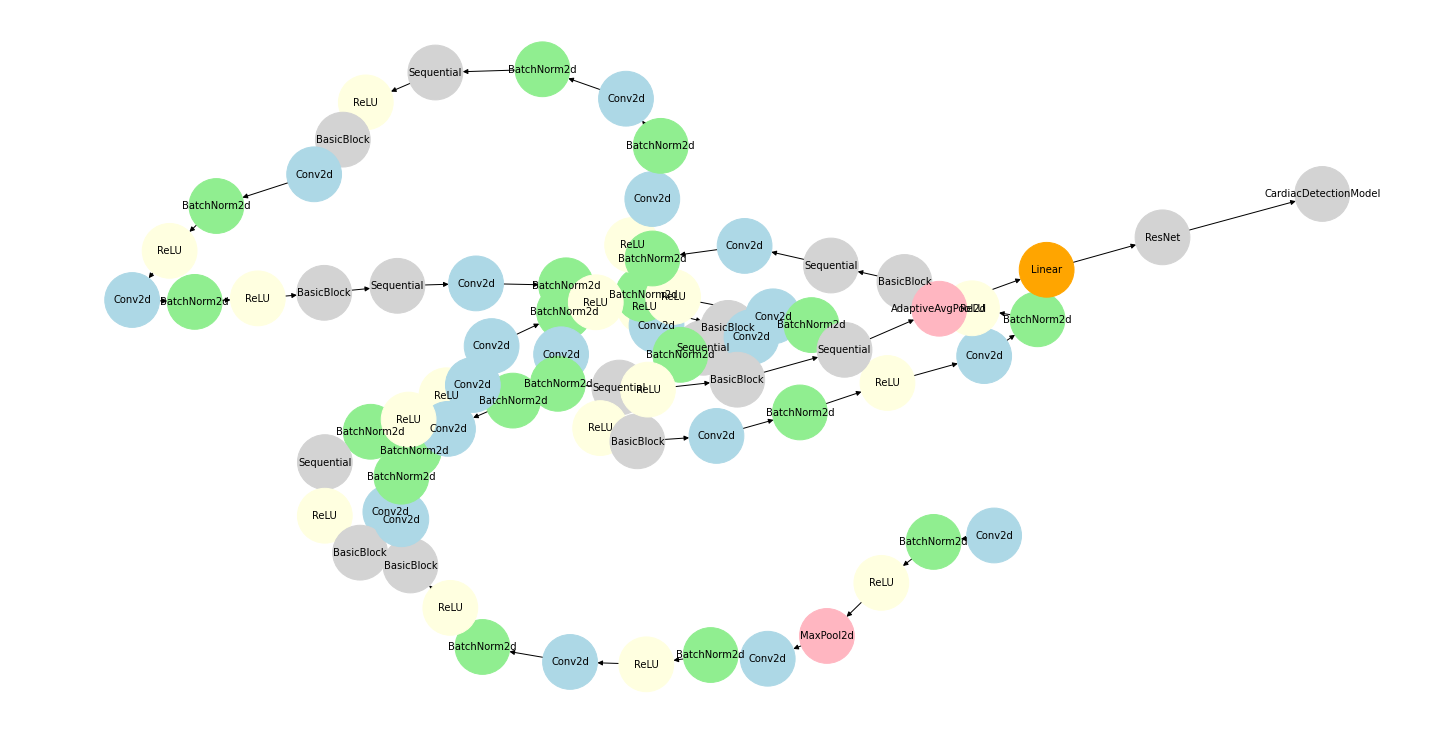

In [68]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import networkx as nx

class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        self.model.fc = nn.Linear(in_features=512, out_features=4)

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CardiacDetectionModel()

# Function to visualize the model in FCNN style
def visualize_model(model):
    layers = []
    layer_types = []
    
    def register_hook(module):
        def hook(module, input, output):
            layer_name = str(module.__class__).split(".")[-1].split("'")[0]
            layers.append(layer_name)
            layer_types.append(module)
        return hook
    
    for name, module in model.named_modules():
        module.register_forward_hook(register_hook(module))
    
    dummy_input = torch.randn(1, 1, 224, 224)
    _ = model(dummy_input)

    G = nx.DiGraph()
    
    for i, (layer, layer_type) in enumerate(zip(layers, layer_types)):
        G.add_node(i, layer=layer)
        if i > 0:
            G.add_edge(i-1, i)
    
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(20, 10))
    node_colors = []
    
    for node in G.nodes(data=True):
        layer = node[1]['layer']
        if 'Conv2d' in layer:
            color = 'lightblue'
        elif 'BatchNorm2d' in layer:
            color = 'lightgreen'
        elif 'ReLU' in layer:
            color = 'lightyellow'
        elif 'MaxPool2d' in layer or 'AdaptiveAvgPool2d' in layer:
            color = 'lightpink'
        elif 'Linear' in layer:
            color = 'orange'
        else:
            color = 'lightgrey'
        node_colors.append(color)
    
    nx.draw(G, pos, with_labels=True, labels={i: l for i, l in enumerate(layers)}, node_size=3000, node_color=node_colors, font_size=10)
    plt.show()

# Visualize the model
visualize_model(model)


/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narendra/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


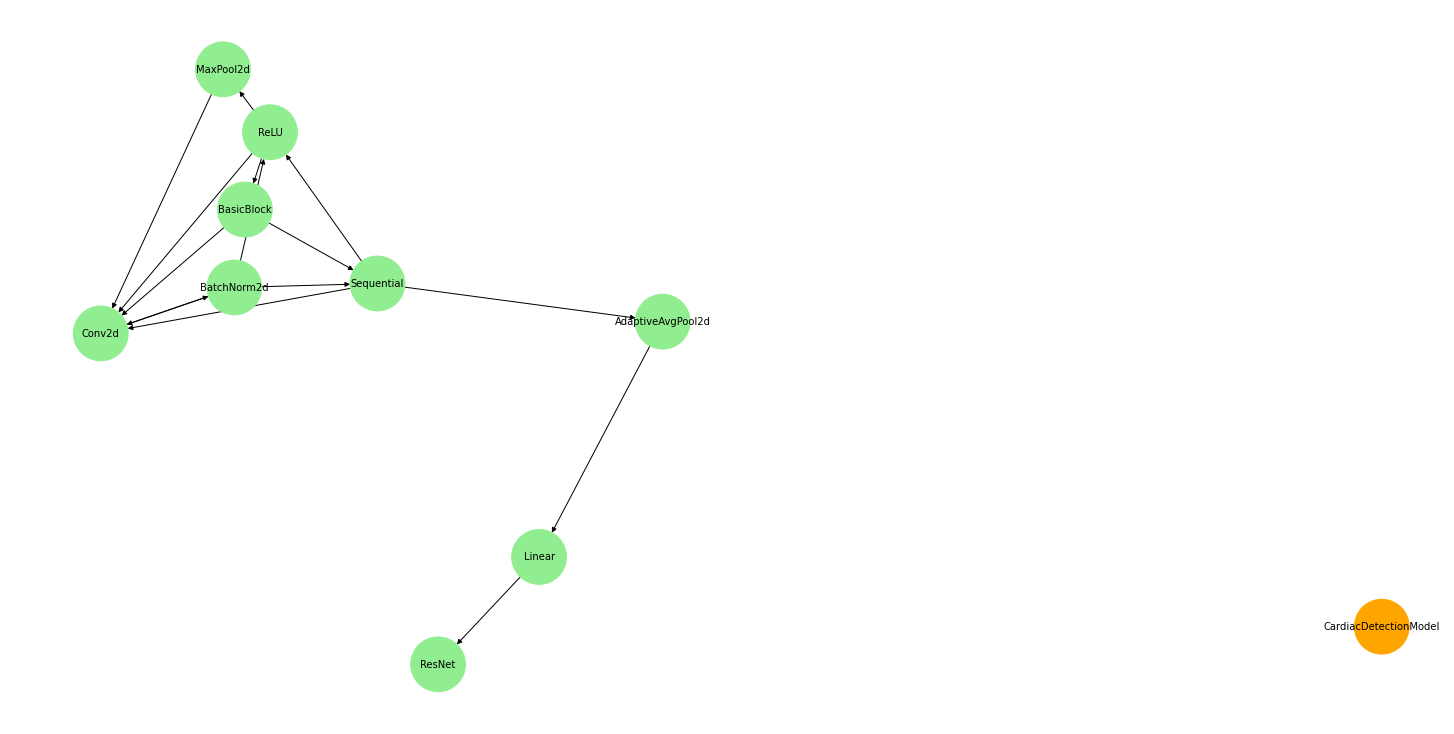

In [69]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import networkx as nx

class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        
        self.model = models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = nn.Linear(in_features=512, out_features=4)

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CardiacDetectionModel()

# Function to visualize the model in FCNN style with input, hidden, and output layers
def visualize_model_fcnn(model):
    layers = []
    layer_types = []
    
    def register_hook(module):
        def hook(module, input, output):
            layer_name = str(module.__class__).split(".")[-1].split("'")[0]
            layers.append(layer_name)
            layer_types.append(module)
        return hook
    
    for name, module in model.named_modules():
        module.register_forward_hook(register_hook(module))
    
    dummy_input = torch.randn(1, 1, 224, 224)
    _ = model(dummy_input)

    G = nx.DiGraph()
    
    input_layer = layers[0]
    hidden_layers = layers[1:-1]  # Exclude input and output layers
    output_layer = layers[-1]
    
    G.add_node(input_layer, layer_type='Input', layer_color='lightblue')
    for layer in hidden_layers:
        G.add_node(layer, layer_type='Hidden', layer_color='lightgreen')
    G.add_node(output_layer, layer_type='Output', layer_color='orange')
    
    for i in range(len(hidden_layers)):
        G.add_edge(layers[i], layers[i+1])
    
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(20, 10))
    node_colors = [data['layer_color'] for node, data in G.nodes(data=True)]
    
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=3000, node_color=node_colors, font_size=10)
    plt.show()

# Visualize the model in FCNN style with input, hidden, and output layers
visualize_model_fcnn(model)


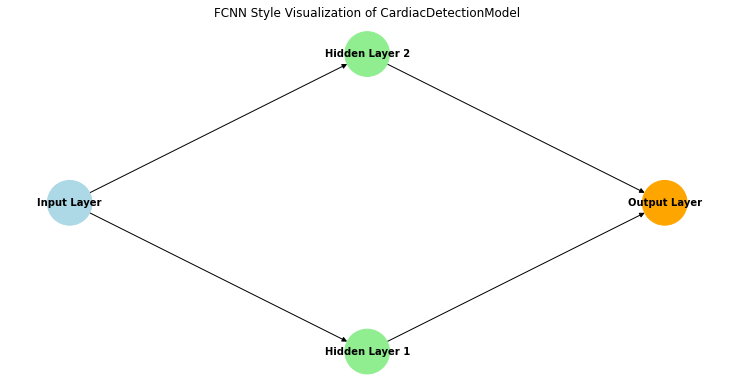

In [70]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx

class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        
        # Define the layers of the model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        # Forward pass through the layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

# Create an instance of the model
model = CardiacDetectionModel()

# Function to visualize the model in FCNN style
def visualize_fcnn(model):
    G = nx.DiGraph()

    # Add input layer
    G.add_node("Input Layer", layer_type="Input", pos=(0, 1))

    # Add hidden layers
    G.add_node("Hidden Layer 1", layer_type="Hidden", pos=(1, 0.6))
    G.add_node("Hidden Layer 2", layer_type="Hidden", pos=(1, 1.4))

    # Add output layer
    G.add_node("Output Layer", layer_type="Output", pos=(2, 1))

    # Connect layers
    G.add_edges_from([("Input Layer", "Hidden Layer 1"), ("Input Layer", "Hidden Layer 2"),
                      ("Hidden Layer 1", "Output Layer"), ("Hidden Layer 2", "Output Layer")])

    # Draw nodes and edges
    node_colors = {"Input": "lightblue", "Hidden": "lightgreen", "Output": "orange"}
    layer_types = nx.get_node_attributes(G, "layer_type")
    node_color = [node_colors[layer_types[node]] for node in G.nodes()]
    pos = nx.get_node_attributes(G, "pos")

    plt.figure(figsize=(10, 5))
    nx.draw(G, pos, with_labels=True, node_color=node_color, node_size=2000, font_size=10, font_weight="bold")
    plt.title("FCNN Style Visualization of CardiacDetectionModel")
    plt.show()

# Visualize the model in FCNN style
visualize_fcnn(model)


In [71]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import tensorflow.keras as keras

class CardiacDetectionModel(nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(512, 4)

    def forward(self, x):
        return self.model(x)

# Create an instance of the model
model = CardiacDetectionModel()

# Extract the fully connected layers (neuron layers)
fc_layers = []
for name, layer in model.named_modules():
    if isinstance(layer, nn.Linear):
        fc_layers.append(layer)

# Create a new Keras model for the fully connected layers
keras_fc_model = keras.models.Sequential()
keras_fc_model.add(keras.layers.InputLayer(input_shape=(512,)))  # Assuming input shape of the fully connected layers is (512,)
for layer in fc_layers:
    keras_fc_model.add(keras.layers.Dense(layer.out_features, use_bias=layer.bias is not None))

# Save the Keras model to a .h5 file
keras_fc_model.save('ResNet18.h5')

/home/narendra/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-06-06 13:37:37.330157: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 13:37:37.330660: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [72]:
import torch
import torch.nn as nn
import tensorflow.keras as keras

# Define a function to extract fully connected layers from the model
def extract_fc_layers(model):
    fc_layers = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            fc_layers.append(module)
    return fc_layers

# Create an instance of the model
model = CardiacDetectionModel()

# Extract fully connected layers
fc_layers = extract_fc_layers(model.model)

# Create a new Keras model containing only the fully connected layers
keras_fc_model = keras.models.Sequential()
for i, layer in enumerate(fc_layers):
    if i == 0:
        keras_fc_model.add(keras.layers.InputLayer(input_shape=(512,)))  # Assuming input size is 512
    keras_fc_model.add(keras.layers.Dense(layer.out_features, use_bias=True))

# Save the Keras model to a .h5 file
keras_fc_model.save('fc_layers_model.h5')


In [73]:
import torchvision.models as models

# resnet101(False)

summary(models.resnet18(False).cuda(), (3, 224, 224))

NameError: name 'summary' is not defined